In [34]:
import pandas as pd
import yfinance as yf
import talib
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
import optuna
import numpy as np
import matplotlib.pyplot as plt

def calculate_technical_indicators(data, params):
    data['SMA'] = data['Close'].rolling(window=params['sma_window']).mean()

    data['RSI'] = talib.RSI(data['Close'], timeperiod=params['rsi_window'])

    data['macd'], data['signal'], _ = talib.MACD(
        data['Close'],
        fastperiod=params['macd_fastperiod'],
        slowperiod=params['macd_slowperiod'],
        signalperiod=params['macd_signalperiod']
    )
    
    return data

def create_features_and_target(data, target_col='Close', window_size=5):
    data['Target'] = data[target_col].shift(-window_size)
    return data.dropna()

def load_data(ticker, start_date, end_date):
    stock_data = yf.download(ticker, start=start_date, end=end_date)
    return stock_data

def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 200),
        'max_depth': trial.suggest_int('max_depth', 5, 15),
        'min_samples_split': trial.suggest_float('min_samples_split', 0.1, 1.0),
        'min_samples_leaf': trial.suggest_float('min_samples_leaf', 0.1, 0.5),
        'sma_window': trial.suggest_int('sma_window', 5, 50),
        'rsi_window': trial.suggest_int('rsi_window', 5, 30),
        'macd_fastperiod': trial.suggest_int('macd_fastperiod', 5, 20),
        'macd_slowperiod': trial.suggest_int('macd_slowperiod', 20, 40),
        'macd_signalperiod': trial.suggest_int('macd_signalperiod', 5, 15),
    }

    data = load_data(ticker, start_date, end_date)
    data = calculate_technical_indicators(data, params)
    data = create_features_and_target(data)

    features = data.drop(['Target'], axis=1)
    target = data['Target']

    tscv = TimeSeriesSplit(n_splits=5)

    mse_scores = []

    for train_index, test_index in tscv.split(features):
        X_train, X_test = features.iloc[train_index], features.iloc[test_index]
        y_train, y_test = target.iloc[train_index], target.iloc[test_index]

        model = RandomForestRegressor(
            n_estimators=params['n_estimators'],
            max_depth=params['max_depth'],
            min_samples_split=params['min_samples_split'],
            min_samples_leaf=params['min_samples_leaf'],
            random_state=42
        )
        model.fit(X_train, y_train)

        predictions = model.predict(X_test)

        mse = mean_squared_error(y_test, predictions)
        mse_scores.append(mse)

    return np.mean(mse_scores)

ticker = 'AAPL'
start_date = '2022-01-01'
end_date = '2023-01-01'

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=5)

best_params = study.best_params
print("Best Parameters:", best_params)

best_model = RandomForestRegressor(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    random_state=42
)
data = load_data(ticker, start_date, end_date)
data = calculate_technical_indicators(data, best_params)
data = create_features_and_target(data)
features = data.drop(['Target'], axis=1)
target = data['Target']
tscv = TimeSeriesSplit(n_splits=5)

mse_scores = []
for train_index, test_index in tscv.split(features):
    X_train, X_test = features.iloc[train_index], features.iloc[test_index]
    y_train, y_test = target.iloc[train_index], target.iloc[test_index]

    best_model.fit(X_train, y_train)
    predictions = best_model.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    mse_scores.append(mse)

print('Final score: {}'.format(np.mean(mse_scores)))

[I 2023-11-27 23:11:55,414] A new study created in memory with name: no-name-e0bb6201-9f2b-4bc6-b228-c58ec094b889


[*********************100%%**********************]  1 of 1 completed


[I 2023-11-27 23:11:55,909] Trial 0 finished with value: 228.36836153766393 and parameters: {'n_estimators': 167, 'max_depth': 13, 'min_samples_split': 0.8863161255476448, 'min_samples_leaf': 0.2107429637995193, 'sma_window': 32, 'rsi_window': 19, 'macd_fastperiod': 9, 'macd_slowperiod': 30, 'macd_signalperiod': 14}. Best is trial 0 with value: 228.36836153766393.


[*********************100%%**********************]  1 of 1 completed


[I 2023-11-27 23:11:56,279] Trial 1 finished with value: 155.5641617251111 and parameters: {'n_estimators': 117, 'max_depth': 8, 'min_samples_split': 0.2118742386607117, 'min_samples_leaf': 0.2442500566953251, 'sma_window': 12, 'rsi_window': 17, 'macd_fastperiod': 12, 'macd_slowperiod': 37, 'macd_signalperiod': 10}. Best is trial 1 with value: 155.5641617251111.


[*********************100%%**********************]  1 of 1 completed


[I 2023-11-27 23:11:56,712] Trial 2 finished with value: 220.34797479424114 and parameters: {'n_estimators': 151, 'max_depth': 6, 'min_samples_split': 0.1201380347700207, 'min_samples_leaf': 0.43094303313319626, 'sma_window': 36, 'rsi_window': 6, 'macd_fastperiod': 20, 'macd_slowperiod': 23, 'macd_signalperiod': 8}. Best is trial 1 with value: 155.5641617251111.


[*********************100%%**********************]  1 of 1 completed

[I 2023-11-27 23:11:56,905] Trial 3 finished with value: 226.86495470408008 and parameters: {'n_estimators': 55, 'max_depth': 15, 'min_samples_split': 0.7829693238912239, 'min_samples_leaf': 0.30866050370122766, 'sma_window': 42, 'rsi_window': 29, 'macd_fastperiod': 20, 'macd_slowperiod': 26, 'macd_signalperiod': 12}. Best is trial 1 with value: 155.5641617251111.



[*********************100%%**********************]  1 of 1 completed


[I 2023-11-27 23:11:57,215] Trial 4 finished with value: 229.83716143559028 and parameters: {'n_estimators': 96, 'max_depth': 12, 'min_samples_split': 0.4395201771135705, 'min_samples_leaf': 0.4555994816215283, 'sma_window': 26, 'rsi_window': 7, 'macd_fastperiod': 6, 'macd_slowperiod': 39, 'macd_signalperiod': 5}. Best is trial 1 with value: 155.5641617251111.


Best Parameters: {'n_estimators': 117, 'max_depth': 8, 'min_samples_split': 0.2118742386607117, 'min_samples_leaf': 0.2442500566953251, 'sma_window': 12, 'rsi_window': 17, 'macd_fastperiod': 12, 'macd_slowperiod': 37, 'macd_signalperiod': 10}
[*********************100%%**********************]  1 of 1 completed
Final score: 155.5641617251111


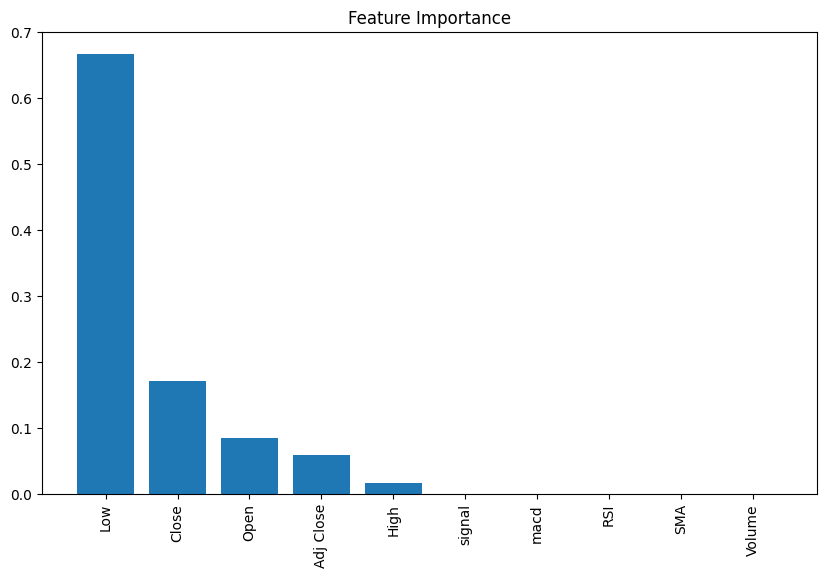

In [35]:
feature_importance = best_model.feature_importances_
feature_names = data.drop(['Target'], axis=1).columns

indices = feature_importance.argsort()[::-1]

plt.figure(figsize=(10, 6))
plt.bar(range(len(indices)), feature_importance[indices], align='center')
plt.xticks(range(len(indices)), feature_names[indices], rotation='vertical')
plt.title('Feature Importance')
plt.show()

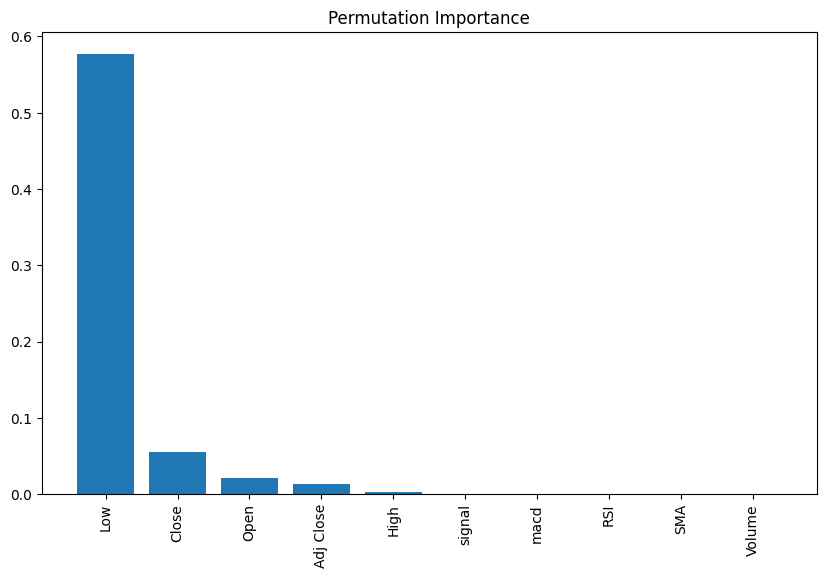

In [36]:
from sklearn.inspection import permutation_importance

perm_importance = permutation_importance(
    best_model,
    data.drop(['Target'], axis=1),
    data['Target'],
    n_repeats=30,
    random_state=42
)

indices = perm_importance.importances_mean.argsort()[::-1]

plt.figure(figsize=(10, 6))
plt.bar(range(len(indices)), perm_importance.importances_mean[indices], align='center')
plt.xticks(range(len(indices)), data.drop(['Target'], axis=1).columns[indices], rotation='vertical')
plt.title('Permutation Importance')
plt.show()